# Dataset Creation 

we have files 
- `resultsAnnotation.tsv`, 
- `datasetAnnotation.tsv`, 
- `taskAnnotation.tsv`, 
- `paper_links.tsv`, 
- `TDM_taxonomy.tsv`, 
- `TDMs_taxonomy.tsv` 
- `paper_name_taxonomy.tsv` 

Created mostly from the file `evaluation-tables.json` from [paperswithcode](https://paperswithcode.com/about)

In [1]:
# imports
import ipdb, os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [16]:
with open(f"../data/resultsAnnotation.tsv", errors='replace') as f:
    resultsAnnotation = f.read().splitlines()

with open(f"../data/datasetAnnotation.tsv", errors='replace') as f:
    datasetAnnotation = f.read().splitlines()
    
with open(f"../data/taskAnnotation.tsv", errors='replace') as f:
    taskAnnotation = f.read().splitlines()
    
with open(f"../data/TDM_taxonomy.tsv", errors='replace') as f:
    TDM_taxonomy = f.read().splitlines()
    
with open(f"../data/paper_name_taxonomy.tsv", errors='replace') as f:
    paper_name_taxonomy = f.read().splitlines()

In [17]:
resultsAnnotation[5]

'1510.05067v4.pdf\tHandwritten Digit Recognition#MNIST#PERCENTAGE ERROR#0.91$Image Classification#STL-10#Percentage correct#57.32$Image Classification#CIFAR-100#Percentage correct#48.75$Image Classification#SVHN#Percentage error#10.16$Image Classification#CIFAR-10#Percentage correct#80.98'

In [18]:
datasetAnnotation[5]

'1510.05067v4.pdf\tMNIST#STL-10#CIFAR-100#SVHN#CIFAR-10'

In [19]:
taskAnnotation[5]

'1510.05067v4.pdf\tHandwritten Digit Recognition'

In [20]:
TDM_taxonomy[9]

'Deblurring#HIDE (trained on GOPRO)#PSNR (sRGB)\t8'

In [21]:
paper_name_taxonomy[5]

'1510.05067v4.pdf\t5'

In [72]:
def create_training_data(path_to_resultsAnnotation, path_to_TDM_taxonomy, path_parsed_files,
                         output_dir, test_set_portion=0.2,
                         leaderboard_threshold=5, num_negative_instances=5, allowed_unknown=10):
    
    # to create the repo if it doesn't exist already 
    if not os.path.exists(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/"):
        os.makedirs(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/")
        
        
    with open(f"{path_to_resultsAnnotation}/resultsAnnotation.tsv", errors='replace') as f:
        resultsAnnotation = f.read().splitlines()
    
    paper_TDM = {}
    for paper in resultsAnnotation:
        if len(paper.split("\t")) != 2:
            continue
            
        title, TDMSList = paper.split("\t")
        
        title = '.'.join(title.split('/')[-1].split('.')[:-1])
        paper_TDM[title] = TDMSList

    with open(f"{path_to_TDM_taxonomy}/TDM_taxonomy.tsv", errors='replace') as f:
        TDM_taxonomy = f.read().splitlines()
        
    TDM_taxonomy_dict = {}
    unknown_count = 0
    for TDMCount in TDM_taxonomy:
        if len(TDMCount.split("\t")) != 2:
            continue
        TDM, count = TDMCount.split("\t")
        count = int(count)
        if count >= leaderboard_threshold:
            TDM_taxonomy_dict[TDM] = count
    # ipdb.set_trace()
    list_parsed_pdf = os.listdir(path_parsed_files)
    if '.ipynb_checkpoints' in list_parsed_pdf:
        list_parsed_pdf.remove('.ipynb_checkpoints')

    
    # ToDo: will it be interresting to use stratified ? using the label ? 
    train_valid = train_test_split(list_parsed_pdf, test_size=10/100, shuffle=True)
    train, valid = train_valid[0], train_valid[1]
    
    if os.path.exists(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/train.tsv"):
        os.remove(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/train.tsv")
        
    if os.path.exists(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/dev.tsv"):
        os.remove(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/dev.tsv")
    
    
    for paper in train :
        with open(f"{path_parsed_files}{paper}", errors='replace') as f:
            txt = f.read().splitlines()
        content = ' '.join(txt)
        # content = re.sub(r"[^a-zA-Z0-9?,'’‘´`%]+", ' ', content).strip()
        content = re.sub(r"[\t]+", ' ', content).strip()
        
        paper_id = '.'.join(paper.split('/')[-1].split('.')[:-1])
        
        not_seen = True
        if paper_id in paper_TDM.keys():
            cache_tdm = set()
            for contrib in paper_TDM[paper_id].split("$"):
                if len(contrib.split("#")) != 4:
                    # missed += 1
                    continue

                task, dataset, metric, score = contrib.split("#")
        
                if (f"{task}#{dataset}#{metric}" in cache_tdm):
                    continue
                
                if f"{task}#{dataset}#{metric}" in TDM_taxonomy_dict.keys():
                    not_seen = False
                    cache_tdm.add(f"{task}#{dataset}#{metric}")
                    with open(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/train.tsv", "a+", encoding="utf-8") as text_file:
                        text_file.write(f"true\t{paper_id}\t{task}#{dataset}#{metric}\t{content}\n")
                        
            if not_seen and (unknown_count <= allowed_unknown):
                with open(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/train.tsv", "a+", encoding="utf-8") as text_file:
                    text_file.write(f"true\t{paper_id}\tunknown\t{content}\n")
                    
                    
            random_tdm =  list(TDM_taxonomy_dict.keys()) 
            random_tdm.sort()
            for RandTDM in random_tdm[:num_negative_instances]:
                task, dataset, metric = RandTDM.split("#")
                with open(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/train.tsv", "a+", encoding="utf-8") as text_file:
                    text_file.write(f"false\t{paper_id}\t{task}#{dataset}#{metric}\t{content}\n")
        else:
            print(f"Paper {paper_id} from train not in the resultsAnnotation.tssv file")
    
    for paper in valid :
        with open(f"{path_parsed_files}{paper}", errors='replace') as f:
            txt = f.read().splitlines()
        content = ' '.join(txt)
        # content = re.sub(r"[^a-zA-Z0-9?,'’‘´`%]+", ' ', content).strip()
        content = re.sub(r"[\t]+", ' ', content).strip()
        
        paper_id = '.'.join(paper.split('/')[-1].split('.')[:-1])
        
        not_seen = True
        if paper_id in paper_TDM.keys():
            cache_tdm = set()
            for contrib in paper_TDM[paper_id].split("$"):
                if len(contrib.split("#")) != 4:
                    # missed += 1
                    continue

                task, dataset, metric, score = contrib.split("#")
        
                if (f"{task}#{dataset}#{metric}" in cache_tdm):
                    continue
                
                if f"{task}#{dataset}#{metric}" in TDM_taxonomy_dict.keys():
                    not_seen = False
                    cache_tdm.add(f"{task}#{dataset}#{metric}")
                    with open(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/dev.tsv", "a+", encoding="utf-8") as text_file:
                        text_file.write(f"true\t{paper_id}\t{task}#{dataset}#{metric}\t{content}\n")
                        
            if not_seen and (unknown_count <= allowed_unknown):
                with open(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/dev.tsv", "a+", encoding="utf-8") as text_file:
                    text_file.write(f"true\t{paper_id}\tunknown\t{content}\n")
                    
                    
            random_tdm =  list(TDM_taxonomy_dict.keys()) 
            random_tdm.sort()
            for RandTDM in random_tdm[:num_negative_instances]:
                task, dataset, metric = RandTDM.split("#")
                with open(f"{output_dir}{num_negative_instances}Neg{allowed_unknown}Unknown/dev.tsv", "a+", encoding="utf-8") as text_file:
                    text_file.write(f"false\t{paper_id}\t{task}#{dataset}#{metric}\t{content}\n")
        else:
            print(f"Paper {paper_id} from validation not in the resultsAnnotation.tssv file")
    
        

In [73]:
path_grobid_full_txt = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/paperwithcode/pdf_txt/"
path_latex_source_tex = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/exp/arxiv_src/"
path_latex_source_pandoc_txt = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/exp/arxiv_src_txt/"

In [86]:
create_training_data(path_to_resultsAnnotation="../data/", \
                         path_to_TDM_taxonomy="../data/", path_parsed_files=path_grobid_full_txt,
                         output_dir="../data/",
                        leaderboard_threshold=5, num_negative_instances=60, allowed_unknown=800)

## View created data

In [1]:
import pandas as pd

In [2]:
train_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/paperwithcode/new/60Neg800unk/twofoldwithunk/fold1/train.tsv"
valid_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/paperwithcode/new/60Neg800unk/twofoldwithunk/fold1/dev.tsv"

In [4]:
train = pd.read_csv(train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

valid = pd.read_csv(valid_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [5]:
train.head()

,label,title,TDM,Context
0,True,1810.02575v1.pdf,Semantic Segmentation; Nighttime Driving; mIoU,Dark Model Adaptation: Semantic Image Segmenta...
1,False,1810.02575v1.pdf,Extractive Text Summarization; DebateSum; ROUGE-L,Dark Model Adaptation: Semantic Image Segmenta...
2,False,1810.02575v1.pdf,Action Recognition; Something-Something V1; To...,Dark Model Adaptation: Semantic Image Segmenta...
3,False,1810.02575v1.pdf,Multi-Object Tracking; MOTS20; sMOTSA,Dark Model Adaptation: Semantic Image Segmenta...
4,False,1810.02575v1.pdf,Continuous Control; PyBullet Ant; Return,Dark Model Adaptation: Semantic Image Segmenta...


In [6]:
train.tail()

,label,title,TDM,Context
256003,False,1307.0414v1.pdf,Skeleton Based Action Recognition; SHREC 2017 ...,Challenges in Representation Learning: A repor...
256004,False,1307.0414v1.pdf,Fake News Detection; FNC-1; Weighted Accuracy,Challenges in Representation Learning: A repor...
256005,False,1307.0414v1.pdf,Multimodal Unsupervised Image-To-Image Transla...,Challenges in Representation Learning: A repor...
256006,False,1307.0414v1.pdf,Graph Classification; PTC; Accuracy,Challenges in Representation Learning: A repor...
256007,False,1307.0414v1.pdf,Pose Estimation; UPenn Action; Mean PCK@0.2,Challenges in Representation Learning: A repor...


In [7]:
valid.head()

,label,title,TDM,Context
0,True,1707.03497v2.pdf,Atari Games; Atari 2600 Seaquest; Score,Value Prediction Network This paper proposes a...
1,True,1707.03497v2.pdf,Atari Games; Atari 2600 Amidar; Score,Value Prediction Network This paper proposes a...
2,True,1707.03497v2.pdf,Atari Games; Atari 2600 Krull; Score,Value Prediction Network This paper proposes a...
3,True,1707.03497v2.pdf,Atari Games; Atari 2600 Alien; Score,Value Prediction Network This paper proposes a...
4,True,1707.03497v2.pdf,Atari Games; Atari 2600 Enduro; Score,Value Prediction Network This paper proposes a...


In [8]:
valid.tail()

,label,title,TDM,Context
108451,False,1909.09051v1.pdf,Image Classification; EMNIST-Balanced; Accuracy,Self-Supervised Monocular Depth Hints Monocula...
108452,False,1909.09051v1.pdf,Question Answering; TrecQA; MAP,Self-Supervised Monocular Depth Hints Monocula...
108453,False,1909.09051v1.pdf,Text Classification; IMDb; Accuracy (10 classes),Self-Supervised Monocular Depth Hints Monocula...
108454,False,1909.09051v1.pdf,Image-to-Image Translation; CelebA-HQ; LPIPS,Self-Supervised Monocular Depth Hints Monocula...
108455,False,1909.09051v1.pdf,Few-Shot Transfer Learning for Saliency Predic...,Self-Supervised Monocular Depth Hints Monocula...


In [9]:
train[train.title=="1911.08251v2"].head()

,label,title,TDM,Context


In [10]:
train[train.TDM=="unknown"].head()

,label,title,TDM,Context


In [11]:
# train["len"]=train.Context.apply(lambda content: len(content.split()),)

# Convert IBM Data to our Data format

This section mostly edit the TDM from the original data from [Hou et al. (2019)](https://arxiv.org/pdf/2004.14356.pdf) by replacing the separator from `,` to `;`. 

**Note**: This section of the notebook can only be run once. 

## NLP-TDMS

### main

In [8]:
IBM_train_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/train.tsv"
IBM_test_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/test.tsv"
# ! cp $IBM_train_csv ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/train_.tsv
# ! cp $IBM_test_csv ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/test_.tsv

In [9]:
train_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

test_IBM = pd.read_csv(IBM_test_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [10]:
train_IBM.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknow,Multi-view Response Selection for Human-Comput...
1,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [13]:
test_IBM.head()

,label,title,TDM,Context
0,True,1803.11175.pdf,sentiment analysis; SUBJ; Accuracy,Universal Sentence Encoder We present models f...
1,True,1803.11175.pdf,text classification; TREC; Error,Universal Sentence Encoder We present models f...
2,False,1803.11175.pdf,question answering; SQuAD; F1,Universal Sentence Encoder We present models f...
3,False,1803.11175.pdf,relation prediction; FB15K-237; H@1,Universal Sentence Encoder We present models f...
4,False,1803.11175.pdf,word sense disambiguation; SemEval 2013; F1,Universal Sentence Encoder We present models f...


In [14]:
train_IBM["TDM"] = train_IBM.TDM.apply(lambda x : re.sub(r"[,]+", ';', x).strip())
test_IBM["TDM"] = test_IBM.TDM.apply(lambda x : re.sub(r"[,]+", ';', x).strip())

train_IBM["TDM"] = train_IBM.TDM.apply(lambda x : "unknown" if x == "unknow" else x)
test_IBM["TDM"] = test_IBM.TDM.apply(lambda x : "unknown" if x == "unknow" else x)

train_IBM["label"] = train_IBM.label.apply(lambda x : str(x).lower())
test_IBM["label"] = test_IBM.label.apply(lambda x : str(x).lower())

In [15]:
train_IBM.head()

,label,title,TDM,Context
0,true,D16-1036.pdf,unknown,Multi-view Response Selection for Human-Comput...
1,false,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,false,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,false,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,false,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [16]:
train_IBM.tail()

,label,title,TDM,Context
13255,false,16165.pdf,dependency parsing; Penn Treebank; LAS,R 3 : Reinforced Ranker-Reader for Open-Domain...
13256,false,16165.pdf,language modeling; Hutter Prize; Number of params,R 3 : Reinforced Ranker-Reader for Open-Domain...
13257,false,16165.pdf,summarization; CNN / Daily Mail (Non-anonymize...,R 3 : Reinforced Ranker-Reader for Open-Domain...
13258,false,16165.pdf,word sense disambiguation; Senseval 3; F1,R 3 : Reinforced Ranker-Reader for Open-Domain...
13259,false,16165.pdf,text classification; TREC; Error,R 3 : Reinforced Ranker-Reader for Open-Domain...


In [17]:
test_IBM.tail()

,label,title,TDM,Context
12631,false,C18-1121.pdf,dependency parsing; Penn Treebank; LAS,Ensure the Correctness of the Summary: Incorpo...
12632,false,C18-1121.pdf,language modeling; Hutter Prize; Number of params,Ensure the Correctness of the Summary: Incorpo...
12633,false,C18-1121.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Ensure the Correctness of the Summary: Incorpo...
12634,false,C18-1121.pdf,word sense disambiguation; Senseval 3; F1,Ensure the Correctness of the Summary: Incorpo...
12635,false,C18-1121.pdf,text classification; TREC; Error,Ensure the Correctness of the Summary: Incorpo...


In [18]:
train_IBM.to_csv(path_or_buf=IBM_train_csv, 
                 sep="\t", header=None, index=False)

test_IBM.to_csv(path_or_buf=IBM_test_csv, 
                 sep="\t", header=None, index=False)

In [19]:
train_v2_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])
test_v2_IBM = pd.read_csv(IBM_test_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [20]:
train_v2_IBM.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknown,Multi-view Response Selection for Human-Comput...
1,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [21]:
test_v2_IBM.tail()

,label,title,TDM,Context
12631,False,C18-1121.pdf,dependency parsing; Penn Treebank; LAS,Ensure the Correctness of the Summary: Incorpo...
12632,False,C18-1121.pdf,language modeling; Hutter Prize; Number of params,Ensure the Correctness of the Summary: Incorpo...
12633,False,C18-1121.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Ensure the Correctness of the Summary: Incorpo...
12634,False,C18-1121.pdf,word sense disambiguation; Senseval 3; F1,Ensure the Correctness of the Summary: Incorpo...
12635,False,C18-1121.pdf,text classification; TREC; Error,Ensure the Correctness of the Summary: Incorpo...


### paperVersion

In [22]:
IBM_train_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train.tsv"
IBM_test_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test.tsv"
# ! cp $IBM_train_csv ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train_.tsv
# ! cp $IBM_test_csv ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test_.tsv

In [23]:
train_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

test_IBM = pd.read_csv(IBM_test_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [24]:
train_IBM.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknow,Multi-view Response Selection for Human-Comput...
1,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [26]:
test_IBM.head()

,label,title,TDM,Context
0,True,1803.11175.pdf,sentiment analysis; SUBJ; Accuracy,Universal Sentence Encoder We present models f...
1,True,1803.11175.pdf,text classification; TREC; Error,Universal Sentence Encoder We present models f...
2,False,1803.11175.pdf,question answering; SQuAD; F1,Universal Sentence Encoder We present models f...
3,False,1803.11175.pdf,relation prediction; FB15K-237; H@1,Universal Sentence Encoder We present models f...
4,False,1803.11175.pdf,word sense disambiguation; SemEval 2013; F1,Universal Sentence Encoder We present models f...


In [27]:
train_IBM["TDM"] = train_IBM.TDM.apply(lambda x : re.sub(r"[,]+", ';', x).strip())
test_IBM["TDM"] = test_IBM.TDM.apply(lambda x : re.sub(r"[,]+", ';', x).strip())

train_IBM["TDM"] = train_IBM.TDM.apply(lambda x : "unknown" if x == "unknow" else x)
test_IBM["TDM"] = test_IBM.TDM.apply(lambda x : "unknown" if x == "unknow" else x)

train_IBM["label"] = train_IBM.label.apply(lambda x : str(x).lower())
test_IBM["label"] = test_IBM.label.apply(lambda x : str(x).lower())

In [28]:
train_IBM.head()

,label,title,TDM,Context
0,true,D16-1036.pdf,unknown,Multi-view Response Selection for Human-Comput...
1,false,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,false,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,false,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,false,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [29]:
train_IBM.tail()

,label,title,TDM,Context
13301,false,16165.pdf,dependency parsing; Penn Treebank; LAS,R 3 : Reinforced Ranker-Reader for Open-Domain...
13302,false,16165.pdf,language modeling; Hutter Prize; Number of params,R 3 : Reinforced Ranker-Reader for Open-Domain...
13303,false,16165.pdf,summarization; CNN / Daily Mail (Non-anonymize...,R 3 : Reinforced Ranker-Reader for Open-Domain...
13304,false,16165.pdf,word sense disambiguation; Senseval 3; F1,R 3 : Reinforced Ranker-Reader for Open-Domain...
13305,false,16165.pdf,text classification; TREC; Error,R 3 : Reinforced Ranker-Reader for Open-Domain...


In [30]:
test_IBM.tail()

,label,title,TDM,Context
13066,false,C18-1121.pdf,dependency parsing; Penn Treebank; LAS,Ensure the Correctness of the Summary: Incorpo...
13067,false,C18-1121.pdf,language modeling; Hutter Prize; Number of params,Ensure the Correctness of the Summary: Incorpo...
13068,false,C18-1121.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Ensure the Correctness of the Summary: Incorpo...
13069,false,C18-1121.pdf,word sense disambiguation; Senseval 3; F1,Ensure the Correctness of the Summary: Incorpo...
13070,false,C18-1121.pdf,text classification; TREC; Error,Ensure the Correctness of the Summary: Incorpo...


In [31]:
train_IBM.to_csv(path_or_buf=IBM_train_csv, 
                 sep="\t", header=None, index=False)

test_IBM.to_csv(path_or_buf=IBM_test_csv, 
                 sep="\t", header=None, index=False)

In [32]:
train_v2_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])
test_v2_IBM = pd.read_csv(IBM_test_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [33]:
train_v2_IBM.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknown,Multi-view Response Selection for Human-Comput...
1,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [34]:
test_v2_IBM.tail()

,label,title,TDM,Context
13066,False,C18-1121.pdf,dependency parsing; Penn Treebank; LAS,Ensure the Correctness of the Summary: Incorpo...
13067,False,C18-1121.pdf,language modeling; Hutter Prize; Number of params,Ensure the Correctness of the Summary: Incorpo...
13068,False,C18-1121.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Ensure the Correctness of the Summary: Incorpo...
13069,False,C18-1121.pdf,word sense disambiguation; Senseval 3; F1,Ensure the Correctness of the Summary: Incorpo...
13070,False,C18-1121.pdf,text classification; TREC; Error,Ensure the Correctness of the Summary: Incorpo...


## ARC-PDN

In [28]:
!tar -xvzf ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/ARC-PDN/test_pdn.tsv.tar.gz -C ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/ARC-PDN/

test_pdn.tsv


In [35]:
IBM_test_pdn_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/ARC-PDN/test_pdn.tsv"
IBM_test_pdn_score_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/ARC-PDN/test_pdn_score.tsv"
# ! cp $IBM_test_pdn_csv ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/ARC-PDN/test_pdn_.tsv
# ! cp $IBM_test_pdn_score_csv ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/ARC-PDN/test_pdn_score_.tsv

In [36]:
test_pdn_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

test_pdn_score_IBM = pd.read_csv(IBM_test_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [37]:
test_pdn_IBM.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknown,Multi-view Response Selection for Human-Comput...
1,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [33]:
test_pdn_score_IBM.head()

,label,title,TDM,Context
0,True,1803.11175.pdf,sentiment analysis; SUBJ; Accuracy,Universal Sentence Encoder We present models f...
1,True,1803.11175.pdf,text classification; TREC; Error,Universal Sentence Encoder We present models f...
2,False,1803.11175.pdf,question answering; SQuAD; F1,Universal Sentence Encoder We present models f...
3,False,1803.11175.pdf,relation prediction; FB15K-237; H@1,Universal Sentence Encoder We present models f...
4,False,1803.11175.pdf,word sense disambiguation; SemEval 2013; F1,Universal Sentence Encoder We present models f...


In [15]:
train_IBM["TDM"] = train_IBM.TDM.apply(lambda x : re.sub(r"[,]+", ';', x).strip())
test_IBM["TDM"] = test_IBM.TDM.apply(lambda x : re.sub(r"[,]+", ';', x).strip())

train_IBM["label"] = train_IBM.label.apply(lambda x : str(x).lower())
test_IBM["label"] = test_IBM.label.apply(lambda x : str(x).lower())

In [16]:
train_IBM.head()

,label,title,TDM,Context
0,true,D16-1036.pdf,unknow,Multi-view Response Selection for Human-Comput...
1,false,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,false,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,false,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,false,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [17]:
train_IBM.tail()

,label,title,TDM,Context
13255,false,16165.pdf,dependency parsing; Penn Treebank; LAS,R 3 : Reinforced Ranker-Reader for Open-Domain...
13256,false,16165.pdf,language modeling; Hutter Prize; Number of params,R 3 : Reinforced Ranker-Reader for Open-Domain...
13257,false,16165.pdf,summarization; CNN / Daily Mail (Non-anonymize...,R 3 : Reinforced Ranker-Reader for Open-Domain...
13258,false,16165.pdf,word sense disambiguation; Senseval 3; F1,R 3 : Reinforced Ranker-Reader for Open-Domain...
13259,false,16165.pdf,text classification; TREC; Error,R 3 : Reinforced Ranker-Reader for Open-Domain...


In [18]:
test_IBM.tail()

,label,title,TDM,Context
12631,false,C18-1121.pdf,dependency parsing; Penn Treebank; LAS,Ensure the Correctness of the Summary: Incorpo...
12632,false,C18-1121.pdf,language modeling; Hutter Prize; Number of params,Ensure the Correctness of the Summary: Incorpo...
12633,false,C18-1121.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Ensure the Correctness of the Summary: Incorpo...
12634,false,C18-1121.pdf,word sense disambiguation; Senseval 3; F1,Ensure the Correctness of the Summary: Incorpo...
12635,false,C18-1121.pdf,text classification; TREC; Error,Ensure the Correctness of the Summary: Incorpo...


In [19]:
train_IBM.to_csv(path_or_buf=IBM_train_csv, 
                 sep="\t", header=None, index=False)

test_IBM.to_csv(path_or_buf=IBM_test_csv, 
                 sep="\t", header=None, index=False)

In [20]:
train_v2_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])
test_v2_IBM = pd.read_csv(IBM_test_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [21]:
train_v2_IBM.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknow,Multi-view Response Selection for Human-Comput...
1,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [22]:
test_v2_IBM.tail()

,label,title,TDM,Context
12631,False,C18-1121.pdf,dependency parsing; Penn Treebank; LAS,Ensure the Correctness of the Summary: Incorpo...
12632,False,C18-1121.pdf,language modeling; Hutter Prize; Number of params,Ensure the Correctness of the Summary: Incorpo...
12633,False,C18-1121.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Ensure the Correctness of the Summary: Incorpo...
12634,False,C18-1121.pdf,word sense disambiguation; Senseval 3; F1,Ensure the Correctness of the Summary: Incorpo...
12635,False,C18-1121.pdf,text classification; TREC; Error,Ensure the Correctness of the Summary: Incorpo...


## Zero-shot

In [34]:
IBM_train_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/zero-shot-setup/NLP-TDMS/train.tsv"
IBM_test_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/zero-shot-setup/NLP-TDMS/test.tsv"
! cp $IBM_train_csv ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/zero-shot-setup/NLP-TDMS/train_.tsv
! cp $IBM_test_csv ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/zero-shot-setup/NLP-TDMS/test_.tsv

In [35]:
train_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

test_IBM = pd.read_csv(IBM_test_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [36]:
train_IBM.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,"retrieval-based chatbot, Ubuntu Corpus, R 2@1",Multi-view Response Selection for Human-Comput...
1,True,D16-1036.pdf,"retrieval-based chatbot, Ubuntu Corpus, R 10@1",Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,"temporal information extraction, TempEval-3, T...",Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,"question answering, SQuAD, F1",Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,"relation prediction, FB15K-237, H@1",Multi-view Response Selection for Human-Comput...


In [37]:
test_IBM.head()

,label,title,TDM,Context
0,True,1806.02847.pdf,"common sense, Winograd Schema Challenge, Accuracy",A Simple Method for Commonsense Reasoning Comm...
1,False,1806.02847.pdf,"temporal information extraction, TempEval-3, T...",A Simple Method for Commonsense Reasoning Comm...
2,False,1806.02847.pdf,"relation prediction, FB15K-237, H@1",A Simple Method for Commonsense Reasoning Comm...
3,False,1806.02847.pdf,"word sense disambiguation, SemEval 2013, F1",A Simple Method for Commonsense Reasoning Comm...
4,False,1806.02847.pdf,"word segmentation, CityU, F1",A Simple Method for Commonsense Reasoning Comm...


In [38]:
train_IBM["TDM"] = train_IBM.TDM.apply(lambda x : re.sub(r"[,]+", ';', x).strip())
test_IBM["TDM"] = test_IBM.TDM.apply(lambda x : re.sub(r"[,]+", ';', x).strip())

train_IBM["label"] = train_IBM.label.apply(lambda x : str(x).lower())
test_IBM["label"] = test_IBM.label.apply(lambda x : str(x).lower())

In [39]:
train_IBM.head()

,label,title,TDM,Context
0,true,D16-1036.pdf,retrieval-based chatbot; Ubuntu Corpus; R 2@1,Multi-view Response Selection for Human-Comput...
1,true,D16-1036.pdf,retrieval-based chatbot; Ubuntu Corpus; R 10@1,Multi-view Response Selection for Human-Comput...
2,false,D16-1036.pdf,temporal information extraction; TempEval-3; T...,Multi-view Response Selection for Human-Comput...
3,false,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
4,false,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...


In [40]:
train_IBM.tail()

,label,title,TDM,Context
20155,false,C18-1121.pdf,language modeling; Hutter Prize; Number of params,Ensure the Correctness of the Summary: Incorpo...
20156,false,C18-1121.pdf,dialogue state tracking; Second dialogue state...,Ensure the Correctness of the Summary: Incorpo...
20157,false,C18-1121.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Ensure the Correctness of the Summary: Incorpo...
20158,false,C18-1121.pdf,named entity recognition; Long-tail emerging e...,Ensure the Correctness of the Summary: Incorpo...
20159,false,C18-1121.pdf,text classification; TREC; Error,Ensure the Correctness of the Summary: Incorpo...


In [41]:
test_IBM.tail()

,label,title,TDM,Context
17383,false,nle07.pdf,dependency parsing; Penn Treebank; LAS,MaltParser: A language-independent system for ...
17384,false,nle07.pdf,question answering; CNN / Daily Mail; Accuracy...,MaltParser: A language-independent system for ...
17385,false,nle07.pdf,summarization; Google Dataset; F1,MaltParser: A language-independent system for ...
17386,false,nle07.pdf,summarization; CNN / Daily Mail (Non-anonymize...,MaltParser: A language-independent system for ...
17387,false,nle07.pdf,named entity recognition; Long-tail emerging e...,MaltParser: A language-independent system for ...


In [42]:
train_IBM.to_csv(path_or_buf=IBM_train_csv, 
                 sep="\t", header=None, index=False)

test_IBM.to_csv(path_or_buf=IBM_test_csv, 
                 sep="\t", header=None, index=False)

In [43]:
train_v2_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])
test_v2_IBM = pd.read_csv(IBM_test_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [44]:
train_v2_IBM.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,retrieval-based chatbot; Ubuntu Corpus; R 2@1,Multi-view Response Selection for Human-Comput...
1,True,D16-1036.pdf,retrieval-based chatbot; Ubuntu Corpus; R 10@1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,temporal information extraction; TempEval-3; T...,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...


In [45]:
test_v2_IBM.tail()

,label,title,TDM,Context
17383,False,nle07.pdf,dependency parsing; Penn Treebank; LAS,MaltParser: A language-independent system for ...
17384,False,nle07.pdf,question answering; CNN / Daily Mail; Accuracy...,MaltParser: A language-independent system for ...
17385,False,nle07.pdf,summarization; Google Dataset; F1,MaltParser: A language-independent system for ...
17386,False,nle07.pdf,summarization; CNN / Daily Mail (Non-anonymize...,MaltParser: A language-independent system for ...
17387,False,nle07.pdf,named entity recognition; Long-tail emerging e...,MaltParser: A language-independent system for ...


In [22]:
IBM_train_csv = "~/Research/task-dataset-metric-nli-extraction/data/pwc_ibm_150_10_10_1000"
IBM_test_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test.tsv"
# ! cp $IBM_train_csv ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train_.tsv
# ! cp $IBM_test_csv ~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test_.tsv

In [23]:
train_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

test_IBM = pd.read_csv(IBM_test_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [24]:
train_IBM.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknow,Multi-view Response Selection for Human-Comput...
1,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [26]:
test_IBM.head()

,label,title,TDM,Context
0,True,1803.11175.pdf,sentiment analysis; SUBJ; Accuracy,Universal Sentence Encoder We present models f...
1,True,1803.11175.pdf,text classification; TREC; Error,Universal Sentence Encoder We present models f...
2,False,1803.11175.pdf,question answering; SQuAD; F1,Universal Sentence Encoder We present models f...
3,False,1803.11175.pdf,relation prediction; FB15K-237; H@1,Universal Sentence Encoder We present models f...
4,False,1803.11175.pdf,word sense disambiguation; SemEval 2013; F1,Universal Sentence Encoder We present models f...


In [27]:
train_IBM["TDM"] = train_IBM.TDM.apply(lambda x : re.sub(r"[,]+", ';', x).strip())
test_IBM["TDM"] = test_IBM.TDM.apply(lambda x : re.sub(r"[,]+", ';', x).strip())

train_IBM["TDM"] = train_IBM.TDM.apply(lambda x : "unknown" if x == "unknow" else x)
test_IBM["TDM"] = test_IBM.TDM.apply(lambda x : "unknown" if x == "unknow" else x)

train_IBM["label"] = train_IBM.label.apply(lambda x : str(x).lower())
test_IBM["label"] = test_IBM.label.apply(lambda x : str(x).lower())

In [28]:
train_IBM.head()

,label,title,TDM,Context
0,true,D16-1036.pdf,unknown,Multi-view Response Selection for Human-Comput...
1,false,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,false,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,false,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,false,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [29]:
train_IBM.tail()

,label,title,TDM,Context
13301,false,16165.pdf,dependency parsing; Penn Treebank; LAS,R 3 : Reinforced Ranker-Reader for Open-Domain...
13302,false,16165.pdf,language modeling; Hutter Prize; Number of params,R 3 : Reinforced Ranker-Reader for Open-Domain...
13303,false,16165.pdf,summarization; CNN / Daily Mail (Non-anonymize...,R 3 : Reinforced Ranker-Reader for Open-Domain...
13304,false,16165.pdf,word sense disambiguation; Senseval 3; F1,R 3 : Reinforced Ranker-Reader for Open-Domain...
13305,false,16165.pdf,text classification; TREC; Error,R 3 : Reinforced Ranker-Reader for Open-Domain...


In [30]:
test_IBM.tail()

,label,title,TDM,Context
13066,false,C18-1121.pdf,dependency parsing; Penn Treebank; LAS,Ensure the Correctness of the Summary: Incorpo...
13067,false,C18-1121.pdf,language modeling; Hutter Prize; Number of params,Ensure the Correctness of the Summary: Incorpo...
13068,false,C18-1121.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Ensure the Correctness of the Summary: Incorpo...
13069,false,C18-1121.pdf,word sense disambiguation; Senseval 3; F1,Ensure the Correctness of the Summary: Incorpo...
13070,false,C18-1121.pdf,text classification; TREC; Error,Ensure the Correctness of the Summary: Incorpo...


In [31]:
train_IBM.to_csv(path_or_buf=IBM_train_csv, 
                 sep="\t", header=None, index=False)

test_IBM.to_csv(path_or_buf=IBM_test_csv, 
                 sep="\t", header=None, index=False)

In [32]:
train_v2_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])
test_v2_IBM = pd.read_csv(IBM_test_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [33]:
train_v2_IBM.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknown,Multi-view Response Selection for Human-Comput...
1,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [34]:
test_v2_IBM.tail()

,label,title,TDM,Context
13066,False,C18-1121.pdf,dependency parsing; Penn Treebank; LAS,Ensure the Correctness of the Summary: Incorpo...
13067,False,C18-1121.pdf,language modeling; Hutter Prize; Number of params,Ensure the Correctness of the Summary: Incorpo...
13068,False,C18-1121.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Ensure the Correctness of the Summary: Incorpo...
13069,False,C18-1121.pdf,word sense disambiguation; Senseval 3; F1,Ensure the Correctness of the Summary: Incorpo...
13070,False,C18-1121.pdf,text classification; TREC; Error,Ensure the Correctness of the Summary: Incorpo...


## DatasetAnnotation

In [72]:
datasetAnnotation_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/paperwithcode/annotations/datasetAnnotation.tsv"
resultsAnnotation_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/paperwithcode/annotations/resultsAnnotation.tsv"
taskAnnotation_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/paperwithcode/annotations/taskAnnotation.tsv"

datasetAnnotation_IBM_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/NLP-TDMS/annotations/datasetAnnotation.tsv"
resultsAnnotation_IBM_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/NLP-TDMS/annotations/resultsAnnotation.tsv"
taskAnnotation_IBM_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/NLP-TDMS/annotations/taskAnnotation.tsv"

In [73]:
datasetAnnotation = pd.read_csv(datasetAnnotation_csv, 
                    sep="\t", names=["label", "datasets"])
resultsAnnotation = pd.read_csv(resultsAnnotation_csv, 
                    sep="\t", names=["label", "TDMS"])
taskAnnotation = pd.read_csv(taskAnnotation_csv, 
                    sep="\t", names=["label", "tasks"])

datasetAnnotation_IBM = pd.read_csv(datasetAnnotation_IBM_csv, 
                    sep="\t", names=["label", "datasets"])
resultsAnnotation_IBM = pd.read_csv(resultsAnnotation_IBM_csv, 
                    sep="\t", names=["label", "TDMS"])
taskAnnotation_IBM = pd.read_csv(taskAnnotation_IBM_csv, 
                    sep="\t", names=["label", "tasks"])

In [74]:
datasetAnnotation_IBM.head()

,label,datasets
0,1705.05952.pdf,UD
1,D18-1205.pdf,CNN / Daily Mail (Non-anonymized version)
2,C18-1121.pdf,Gigaword#DUC 2004 Task 1
3,P18-1063.pdf,CNN / Daily Mail (Anonymized version)
4,5635-grammar-as-a-foreign-language.pdf,Penn Treebank


In [75]:
datasetAnnotation.head()

,label,datasets
0,1704.03549v4.pdf,FSNS - Test
1,1712.05404.pdf,FSNS - Test
2,1702.03970v1.pdf,FSNS - Test
3,2104.02324v1.pdf,COCO#PASCAL VOC 07+12#PASCAL VOC 07+12#COCO#PA...
4,2008.12995v3.pdf,BanglaLekha Isolated Dataset#BanglaLekha Isola...


In [76]:
resultsAnnotation.tail()

,label,TDMS
5726,2104.01378v1.pdf,Phone-level pronunciation scoring#speechocean7...
5727,2104.10283v1.pdf,Graph Question Answering#GQA#Accuracy#96.30
5728,2104.11980v1.pdf,Trajectory Modeling#NBA SportVU#1x1 NLL#0.472
5729,1704.00077v1.pdf,Video Segmentation#SegTrack v2#Accuracy#86.86
5730,2004.07922v1.pdf,Document Text Classification#Tobacco small-348...


In [71]:
resultsAnnotation_IBM.tail()

,label,TDMS
341,1704.08381.pdf,amr_parsing#LDC2015E86#Smatch#62.1
342,1803.09074.pdf,question_answering#RACE#Accuracy on RACE-m#60....
343,1602.02373.pdf,text_classification#AG News#Error#6.57$text_cl...
344,N18-2108.pdf,coreference_resolution#CoNLL 2012#Avg F1#73.0
345,P17-1089.pdf,sql_parsing#ATIS#Question Split#45$sql_parsing...


In [81]:
taskAnnotation.tail()

,label,tasks
5724,2104.01378v1.pdf,Phone-level pronunciation scoring
5725,2104.10283v1.pdf,Graph Question Answering
5726,2104.11980v1.pdf,Trajectory Modeling
5727,1704.00077v1.pdf,Video Segmentation
5728,2004.07922v1.pdf,Document Text Classification


In [78]:
taskAnnotation_IBM.tail()

,label,tasks
342,1704.08381.pdf,amr_parsing
343,1803.09074.pdf,question_answering
344,1602.02373.pdf,sentiment_analysis
345,N18-2108.pdf,coreference_resolution
346,P17-1089.pdf,sql_parsing


In [166]:
with open(f"/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test.tsv") as f:
    list_test_IBM = f.read().splitlines()

# with open(f"/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test_results_IBM.tsv") as f:
with open(f"/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/paperwithcode/new/60Neg800unk/twofoldwithunk/fold1/models/SciBERT/test_results.tsv") as f:
# with open(f"/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/paperwithcode/new/jar/80Neg600unk/twofoldwithunk/fold1/models/cased_L-12_H-768_A-12_XLNet/test_results.tsv") as f:
    list_test_IBM_results = f.read().splitlines()

In [167]:
len(list_test_IBM_results)

13071

In [168]:
assert len(list_test_IBM) == len(list_test_IBM_results), "Error in Lenght"

In [169]:
list_test_IBM[-1].split("\t")[0]

'false'

In [170]:
list_test_IBM_results[0].split("\t")

['0.9912383', '0.008761689']

In [171]:
tp, fn, tn, fp = 0, 0, 0, 0
y = []
y_pred = []
# here 0: true, 1: false
for idx in range(len(list_test_IBM)):
    true_label = list_test_IBM[idx].split("\t")[0]
    true, false = list_test_IBM_results[idx].split("\t")
    true, false = float(true), float(false)
    if true_label=='true' :
        y.append(0)
        if true > false:
            tp += 1
            y_pred.append(0)
        else:
            fn += 1
            y_pred.append(1)
    else:
        y.append(1)
        if false > true:
            tn += 1
            y_pred.append(1)
        else:
            fp += 1    
            y_pred.append(0)

In [172]:
# print(f"TP: {tp} FN: {fn} TN: {tn} FP: {fp}")
# precision = tp/(tp+fp)
# recall = tp/(tp+fn)
# f1 = 2 * (precision * recall) / (precision + recall)
# print(f"Precision: {precision} Recall: {recall} and F1 = {f1}")

# classification_report(y, y_pred, target_names=["true", "false"], output_dict=True)

In [165]:
print(f"precision_score (macro): {precision_score(y, y_pred, average ='macro')}")
print(f"recall_score (macro): {recall_score(y, y_pred, average ='macro')}")
print(f"f1_score (macro): {f1_score(y, y_pred, average ='macro')}")
print(f"precision_score (micro): {precision_score(y, y_pred, average ='micro')}")
print(f"recall_score (micro): {recall_score(y, y_pred, average ='micro')}")
print(f"f1_score (micro): {f1_score(y, y_pred, average ='micro')}")
print(f"Avg. {round((f1_score(y, y_pred, average ='macro')+f1_score(y, y_pred, average ='micro'))/2, 4)}")

# metrics_dict = classification_report(y, y_pred, target_names=["true", "false"], output_dict=True)['macro avg']
# print(f"precision macro avg: {metrics_dict['precision']}")
# print(f"recall macro avg: {metrics_dict['recall']}")
# print(f"f1-score macro avg: {metrics_dict['f1-score']}")


precision_score (macro): 0.7972994801609445
recall_score (macro): 0.8752512657119265
f1_score (macro): 0.8313975319966176
precision_score (micro): 0.9807206793665366
recall_score (micro): 0.9807206793665366
f1_score (micro): 0.9807206793665366
Avg. 0.9061


In [173]:
print(f"precision_score (macro): {precision_score(y, y_pred, average ='macro')}")
print(f"recall_score (macro): {recall_score(y, y_pred, average ='macro')}")
print(f"f1_score (macro): {f1_score(y, y_pred, average ='macro')}")
print(f"precision_score (micro): {precision_score(y, y_pred, average ='micro')}")
print(f"recall_score (micro): {recall_score(y, y_pred, average ='micro')}")
print(f"f1_score (micro): {f1_score(y, y_pred, average ='micro')}")
print(f"Avg. {round((f1_score(y, y_pred, average ='macro')+f1_score(y, y_pred, average ='micro'))/2, 3)}")

# metrics_dict = classification_report(y, y_pred, target_names=["true", "false"], output_dict=True)['macro avg']
# print(f"precision macro avg: {metrics_dict['precision']}")
# print(f"recall macro avg: {metrics_dict['recall']}")
# print(f"f1-score macro avg: {metrics_dict['f1-score']}")

precision_score (macro): 0.6988143433708494
recall_score (macro): 0.9431944873067374
f1_score (macro): 0.7690540615635835
precision_score (micro): 0.9620534006579451
recall_score (micro): 0.9620534006579451
f1_score (micro): 0.9620534006579451
Avg. 0.866


In [156]:
round(0.9620534006579451, 3)

0.962

# Data clearning

### paperVerion

In [27]:
test_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

train_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

paper_links_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/NLP-TDMS/downloader/paper_links.tsv", 
                    sep="\t", names=["pdf", "link", "hashCode"])

path_pdf_IBM_Original = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Original"

In [28]:
train_IBM_pd.tail()

,label,title,TDM,Context
13301,False,16165.pdf,dependency parsing; Penn Treebank; LAS,R 3 : Reinforced Ranker-Reader for Open-Domain...
13302,False,16165.pdf,language modeling; Hutter Prize; Number of params,R 3 : Reinforced Ranker-Reader for Open-Domain...
13303,False,16165.pdf,summarization; CNN / Daily Mail (Non-anonymize...,R 3 : Reinforced Ranker-Reader for Open-Domain...
13304,False,16165.pdf,word sense disambiguation; Senseval 3; F1,R 3 : Reinforced Ranker-Reader for Open-Domain...
13305,False,16165.pdf,text classification; TREC; Error,R 3 : Reinforced Ranker-Reader for Open-Domain...


In [29]:
test_IBM_pd.tail()

,label,title,TDM,Context
13066,False,C18-1121.pdf,dependency parsing; Penn Treebank; LAS,Ensure the Correctness of the Summary: Incorpo...
13067,False,C18-1121.pdf,language modeling; Hutter Prize; Number of params,Ensure the Correctness of the Summary: Incorpo...
13068,False,C18-1121.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Ensure the Correctness of the Summary: Incorpo...
13069,False,C18-1121.pdf,word sense disambiguation; Senseval 3; F1,Ensure the Correctness of the Summary: Incorpo...
13070,False,C18-1121.pdf,text classification; TREC; Error,Ensure the Correctness of the Summary: Incorpo...


In [30]:
paper_links_pd.head()

,pdf,link,hashCode
0,1705.05952.pdf,https://arxiv.org/pdf/1705.05952.pdf,fa507bb9b71735760388dda965c8d676
1,C18-1121.pdf,http://aclweb.org/anthology/C18-1121,810ea6e211512f049940e945ddf47e96
2,D18-1205.pdf,http://aclweb.org/anthology/D18-1205,b0921e9016f0ebd4c1a4b467d17bcb18
3,P18-1063.pdf,http://aclweb.org/anthology/P18-1063,4d573757d6419edc2d8c0bb9d4d3ec6b
4,5635-grammar-as-a-foreign-language.pdf,https://papers.nips.cc/paper/5635-grammar-as-a...,c42e59f47a0d9dc254efb7ec3bc11b88


In [31]:
# path_pdf_IBM_Original

In [32]:
# test_IBM_pd[test_IBM_pd.label==True].head()

In [33]:
# List of pdf name that are in the test file
list_train_IBM_uniq = list(train_IBM_pd.title.unique())
len(list_train_IBM_uniq)

170

In [34]:
# List of pdf name that are in the train file
list_test_IBM_uniq = list(test_IBM_pd.title.unique())
len(list_test_IBM_uniq)

167

In [35]:
# total number of uniq pdf in the train and testing
len(list_test_IBM_uniq)+len(list_train_IBM_uniq)

337

In [36]:
# List of number unique file in main pdf folder 
list_paper_links_uniq = list(paper_links_pd.pdf.unique())
len(list_paper_links_uniq)

348

In [37]:
list_pdf_IBM_Original = os.listdir("/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Original")
len(list_pdf_IBM_Original)

346

In [44]:
count = 0
missing_list = []
for pdf in list_test_IBM_uniq:
#     if pdf not in list_pdf_IBM_Original:
    if pdf not in list_pdf_IBM_Original:
#         print(pdf)
        count+=1
        missing_list.append(pdf)
print(count)

0


In [43]:
missing_list

['htyo14.pdf', '16137.pdf']

In [38]:
count = 0
missing_list = []
for pdf in list_pdf_IBM_Original:
#     if pdf not in list_pdf_IBM_Original:
    if pdf not in list_test_IBM_uniq and  pdf not in list_train_IBM_uniq:
#         print(pdf)
        count+=1
        missing_list.append(pdf)
print(count)

9


In [39]:
# The following pdf don't have taxonomy in the original IBM released metadata
missing_list

['1811.08619.pdf',
 'D13-1090.pdf',
 '847.pdf',
 '1506.03340.pdf',
 'forum_id_BJEX_H1Pf.pdf',
 'cikm2014.pdf',
 'coli_a_00164.pdf',
 'N16-1020.pdf',
 '1410.5401.pdf']

In [40]:
pdf_path = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Original/"
output_path = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Original_Clean/"

if not (os.path.exists(output_path)):
    os.makedirs(output_path)

for pdf in list_pdf_IBM_Original:
    if pdf not in list_test_IBM_uniq and  pdf not in list_train_IBM_uniq:
        print(f"Pdf {pdf} not used in train nor test, skiped")
    else:
        !cp $pdf_path$pdf $output_path 
        
len(os.listdir(pdf_path))==len(os.listdir(output_path))+len(missing_list)

Pdf 1811.08619.pdf not used in train nor test, skiped
Pdf D13-1090.pdf not used in train nor test, skiped
Pdf 847.pdf not used in train nor test, skiped
Pdf 1506.03340.pdf not used in train nor test, skiped
Pdf forum_id_BJEX_H1Pf.pdf not used in train nor test, skiped
Pdf cikm2014.pdf not used in train nor test, skiped
Pdf coli_a_00164.pdf not used in train nor test, skiped
Pdf N16-1020.pdf not used in train nor test, skiped
Pdf 1410.5401.pdf not used in train nor test, skiped


True

In [41]:
# len(os.listdir(pdf_path))==len(os.listdir(output_path))+len(missing_list)

In [17]:
count = 0
missing_list = []
for pdf in list_pdf_IBM_Original:
#     if pdf not in list_pdf_IBM_Original:
    if pdf not in list_paper_links_uniq:
#         print(pdf)
        count+=1
        missing_list.append(pdf)
print(count)

0


In [62]:
import ipdb

In [45]:
# for pdf in missing_list:
#     print(paper_links_pd[paper_links_pd.pdf==pdf])
#     ipdb.set_trace()
    

### Create separate train, test folder as per the original data split

In [50]:
pdf_path = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Original/"
output_path = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Test_Paper_Version/"

for pdf in list_test_IBM_uniq:
    !cp $pdf_path$pdf $output_path 
len(os.listdir("/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Test_Paper_Version"))==len(list_test_IBM_uniq)

True

In [57]:
pdf_path = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Original/"
output_path = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Train_Paper_Version/"

for pdf in list_train_IBM_uniq:
    !cp $pdf_path$pdf $output_path 
len(os.listdir("/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Train_Paper_Version"))==len(list_train_IBM_uniq)-2

cp: cannot stat '/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Original/htyo14.pdf': No such file or directory
cp: cannot stat '/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Original/16137.pdf': No such file or directory


True

In [77]:
# Remove test pdf in the main dataset folder 

In [79]:
len(os.listdir("/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/"))

5401

In [80]:
len(list_test_IBM_uniq)

167

In [81]:
len(os.listdir("/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/"))-len(list_test_IBM_uniq)

5234

In [82]:
pdf_path = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/"
output_path = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Train_Paper_Version/"

for pdf in os.listdir(pdf_path):
    if pdf in list_test_IBM_uniq:
        !rm $pdf_path$pdf

In [99]:
len(os.listdir(pdf_path))

5374

In [91]:
pdf_path = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/"
pdf_train_path = "/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Train_Paper_Version/"

for pdf in os.listdir(pdf_train_path):
    !cp $pdf_train_path$pdf $pdf_path 
# len(os.listdir("/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM_Train_Paper_Version"))==len(list_train_IBM_uniq)-2

In [92]:
len(os.listdir(pdf_path))

5374

In [96]:
count = 0
missing_list = []
for pdf in list_train_IBM_uniq:
    if pdf not in os.listdir(pdf_path):
        print(pdf)
        count+=1
        missing_list.append(pdf)
print(count)

htyo14.pdf
1


In [97]:
missing_list

['htyo14.pdf']

# Zero shot setup

In [68]:
test2_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/test.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

train2_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/train.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

# paper_links_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/NLP-TDMS/downloader/paper_links.tsv", 
#                     sep="\t", names=["pdf", "link", "hashCode"])

In [70]:
len(list_train_IBM_uniq)

170

In [71]:
list_train2_IBM_uniq = list(train2_IBM_pd.title.unique())
len(list_train2_IBM_uniq)

170

In [74]:
len(list_test_IBM_uniq)

167

In [73]:
# List of pdf name that are in the train file
list_test2_IBM_uniq = list(test2_IBM_pd.title.unique())
len(list_test_IBM_uniq)

167

In [76]:
count = 0
missing_list = []
for pdf in list_test2_IBM_uniq:
#     if pdf not in list_pdf_IBM_Original:
    if pdf not in list_pdf_IBM_Original:
#         print(pdf)
        count+=1
        missing_list.append(pdf)
print(count)

2


## Check the balance between classes

### IBM

In [2]:
test_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

train_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [3]:
train_IBM_pd.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknow,Multi-view Response Selection for Human-Comput...
1,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [11]:
train_IBM_pd[train_IBM_pd.label==True].count()

label      373
title      373
TDM        373
Context    373
dtype: int64

In [10]:
train_IBM_pd[train_IBM_pd.label==True].nunique()

label        1
title      170
TDM         79
Context    169
dtype: int64

In [20]:
# train_IBM_pd_true = train_IBM_pd[train_IBM_pd.label==True]

# train_IBM_pd_true[train_IBM_pd_true.title.duplicated()]

In [8]:
train_IBM_pd[train_IBM_pd.label==False].count()

label      12933
title      12933
TDM        12933
Context    12933
dtype: int64

## Update the IBM train and test data to our generated context

In [2]:
train_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

test_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])


trainOutput_150_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/IBM_jar_150/0Neg1000unk/trainOutput.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

trainOutput_full_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/IBM_jar_full/0Neg1000unk/trainOutput.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

# path_train_150 = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train_150.tsv"
# path_train_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train_full.tsv"

In [3]:
trainOutput_150_IBM_pd.tail()

,label,title,TDM,Context
810,True,S17-2080.pdf,unknown,UWaterloo at SemEval-2017 Task 8: Detecting St...
811,True,N18-2009.pdf,summarization; CNN / Daily Mail (Anonymized ve...,Guiding Generation for Abstractive Text Summar...
812,True,N18-2009.pdf,summarization; CNN / Daily Mail (Anonymized ve...,Guiding Generation for Abstractive Text Summar...
813,True,N18-2009.pdf,summarization; CNN / Daily Mail (Anonymized ve...,Guiding Generation for Abstractive Text Summar...
814,True,N18-2009.pdf,summarization; CNN / Daily Mail (Anonymized ve...,Guiding Generation for Abstractive Text Summar...


In [4]:
trainOutput_full_IBM_pd.head()

,label,title,TDM,Context
0,True,64f0dab74295e5eb139c160ed79ff262558a.pdf,constituency_parsing; Penn Treebank; F1,Effective Self-Training for Parsing We present...
1,True,D18-1205.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Improving Neural Abstractive Document Summariz...
2,True,D18-1205.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Improving Neural Abstractive Document Summariz...
3,True,D18-1205.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Improving Neural Abstractive Document Summariz...
4,True,D18-1205.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Improving Neural Abstractive Document Summariz...


### train_IBM_pd vs trainOutput_150_IBM_pd

In [5]:
train_IBM_pd[train_IBM_pd.label==True].head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknown,Multi-view Response Selection for Human-Comput...
79,True,1803.09074.pdf,unknown,Multi-range Reasoning for Machine Comprehensio...
158,True,1806.06228.pdf,unknown,Multimodal Sentiment Analysis using Hierarchic...
237,True,P17-1127.pdf,unknown,Can Syntax Help? Improving an LSTM-based Sente...
316,True,1602.02373.pdf,text classification; DBpedia; Error,Supervised and Semi-Supervised Text Categoriza...


In [6]:
trainOutput_150_IBM_pd.head()

,label,title,TDM,Context
0,True,64f0dab74295e5eb139c160ed79ff262558a.pdf,constituency_parsing; Penn Treebank; F1,Effective Self-Training for Parsing We present...
1,True,D18-1205.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Improving Neural Abstractive Document Summariz...
2,True,D18-1205.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Improving Neural Abstractive Document Summariz...
3,True,D18-1205.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Improving Neural Abstractive Document Summariz...
4,True,D18-1205.pdf,summarization; CNN / Daily Mail (Non-anonymize...,Improving Neural Abstractive Document Summariz...


In [7]:
train_IBM_pd.title.unique()[:2]

array(['D16-1036.pdf', '1803.09074.pdf'], dtype=object)

In [9]:
# list_trainOutput_150_IBM_pd_uniq[:2]

In [10]:
# List of pdf name that are in the test file
list_train_IBM_uniq = list(train_IBM_pd.title.unique())
len(list_train_IBM_uniq)

170

In [11]:
# List of pdf name that are in the train file
list_test_IBM_uniq = list(test_IBM_pd.title.unique())
len(list_test_IBM_uniq)

167

In [12]:
# total number of uniq pdf in the train and testing
len(list_test_IBM_uniq)+len(list_train_IBM_uniq)

337

In [13]:
# List of pdf name that are in the train file
list_trainOutput_150_IBM_pd_uniq = list(trainOutput_150_IBM_pd.title.unique())
len(list_trainOutput_150_IBM_pd_uniq)

337

In [14]:
# List of pdf name that are in the train file
list_trainOutput_full_IBM_pd_uniq = list(trainOutput_full_IBM_pd.title.unique())
len(list_trainOutput_full_IBM_pd_uniq)

337

In [15]:
# Dict to contains new context

dict_150_paper_context = {}
for paper in list_trainOutput_150_IBM_pd_uniq:
    dict_150_paper_context[paper]=trainOutput_150_IBM_pd[trainOutput_150_IBM_pd.title==paper].Context.values[0]
    
dict_original_paper_context = {}
for paper in list_train_IBM_uniq:
    dict_original_paper_context[paper]=train_IBM_pd[train_IBM_pd.title==paper].Context.values[0]
for paper in list_test_IBM_uniq:
    dict_original_paper_context[paper]=test_IBM_pd[test_IBM_pd.title==paper].Context.values[0]
    
    
dict_full_paper_context = {}
for paper in list_trainOutput_full_IBM_pd_uniq:
    dict_full_paper_context[paper]=trainOutput_full_IBM_pd[trainOutput_full_IBM_pd.title==paper].Context.values[0]

In [74]:
def get_start_lenght(dictionary, limit="150", title="",):
    # Stats
    len_context= []
    for context in dictionary.values():
        len_context.append(len(context.split()))
    
    print(f"Context TDM limit {limit}:")
    print(f"Mean lenght: {np.mean(len_context)}")
    print(f"Max lenght: {np.max(len_context)}")
    print(f"Min lenght: {np.min(len_context)}")
    print(f"Std lenght: {np.std(len_context)}")
    
    x = np.arange(1, len(len_context)+1, 1)
    y = len_context

    plt.plot(x, y)

    plt.title(title)
    plt.xlabel("number of papers")
    plt.ylabel("lenght DocTAET")
    plt.savefig(fname=re.sub(r"[0-9]+", '', title).strip())
    plt.show()
    
    return len_context

Context TDM limit 150:
Mean lenght: 309.6706231454006
Max lenght: 546
Min lenght: 81
Std lenght: 94.29262551239724


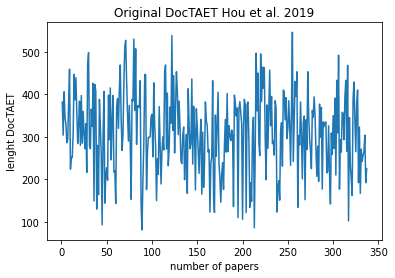

In [75]:
len_context_150 = get_start_lenght(dict_150_paper_context, 
                                   limit="150", 
                                   title="Original DocTAET Hou et al. 2019")

Context TDM limit IBM Original:
Mean lenght: 309.45103857566767
Max lenght: 546
Min lenght: 81
Std lenght: 93.92587269350176


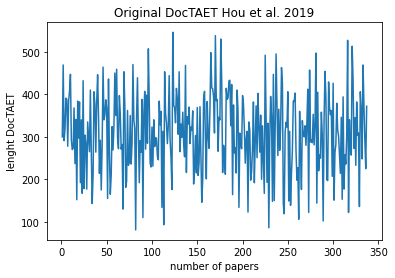

In [76]:
len_context_original = get_start_lenght(dict_original_paper_context, 
                                        limit="IBM Original",
                                       title="Original DocTAET Hou et al. 2019")

Context TDM limit full:
Mean lenght: 374.7091988130564
Max lenght: 1220
Min lenght: 81
Std lenght: 172.08599311150843


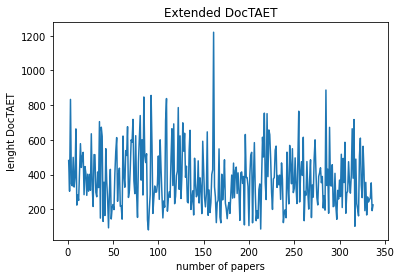

In [77]:
len_context_full = get_start_lenght(dict_full_paper_context, 
                                    limit="full",
                                    title="Extended DocTAET")

In [20]:
train_IBM_pd.head()

,label,title,TDM,Context
0,True,D16-1036.pdf,unknown,Multi-view Response Selection for Human-Comput...
1,False,D16-1036.pdf,question answering; SQuAD; F1,Multi-view Response Selection for Human-Comput...
2,False,D16-1036.pdf,relation prediction; FB15K-237; H@1,Multi-view Response Selection for Human-Comput...
3,False,D16-1036.pdf,word sense disambiguation; SemEval 2013; F1,Multi-view Response Selection for Human-Comput...
4,False,D16-1036.pdf,language modeling; 1B Words / Google Billion W...,Multi-view Response Selection for Human-Comput...


In [21]:
np.arange(1, 5, 1)

array([1, 2, 3, 4])

TypeError: 'str' object is not callable

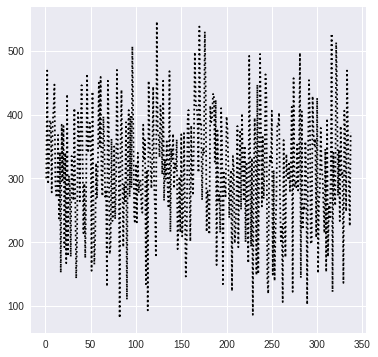

In [245]:

  
# To generate an array of x-values
x = np.arange(1, len(len_context_original)+1, 1)

# To generate an array of
# y-values using corresponding x-values
y = len_context_original

# def pdf(x):
#     mean = np.mean(x)
#     std = np.std(x)
#     y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
#     return y_out
  
# # To generate an array of x-values
# x = np.arange(-2, 2, 0.1)
  
# # To generate an array of 
# # y-values using corresponding x-values
# y = pdf(x)
  

  
# Plotting the bell-shaped curve
plt.style.use('seaborn')
plt.figure(figsize = (6, 6))
plt.plot(x, y, color = 'black',
     linestyle = ':')
plt.xlabel("len tokens")
plt.ylabel("Papers count")
  
plt.scatter( x, y, marker = 'o', s = 25, color = 'red')
plt.show()

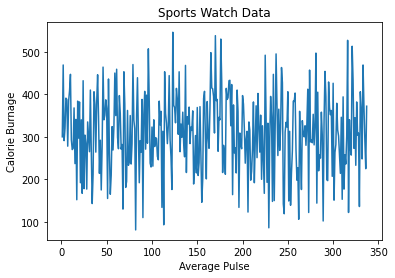

In [34]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, len(len_context_original)+1, 1)
y = len_context_original

plt.plot(x, y)

plt.title("Sports Watch Data")
plt.xlabel("Average Pulse")
plt.ylabel("Calorie Burnage")
plt.savefig("test")
plt.show()


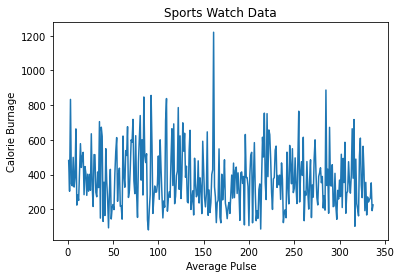

In [24]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, len(len_context_full)+1, 1)
y = len_context_full

plt.plot(x, y)

plt.title("Sports Watch Data")
plt.xlabel("Average Pulse")
plt.ylabel("Calorie Burnage")

plt.show()

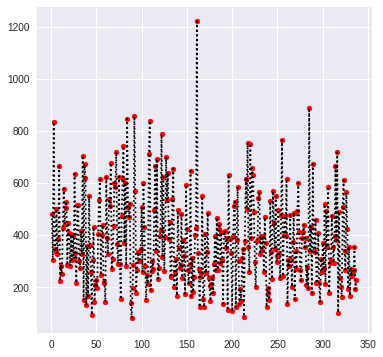

In [237]:
# To generate an array of x-values
x = np.arange(1, len(len_context_full)+1, 1)
  
# To generate an array of
# y-values using corresponding x-values
y = len_context_full
  
# Plotting the bell-shaped curve
plt.style.use('seaborn')
plt.figure(figsize = (6, 6))
plt.plot(x, y, color = 'black',
     linestyle = ':')
  
plt.scatter( x, y, marker = 'o', s = 25, color = 'red')
plt.show()

In [142]:
train_IBM_pd["Context"] = train_IBM_pd.apply(lambda x : dict_full_paper_context[x['title']] if x['title'] in dict_full_paper_context.keys() else "None", axis=1)
test_IBM_pd["Context"] = test_IBM_pd.apply(lambda x : dict_full_paper_context[x['title']] if x['title'] in dict_full_paper_context.keys() else "None", axis=1)

In [143]:
# Verification
dict_original_paper_context = {}
for paper in list_train_IBM_uniq:
    dict_original_paper_context[paper]=train_IBM_pd[train_IBM_pd.title==paper].Context.values[0]
for paper in list_test_IBM_uniq:
    dict_original_paper_context[paper]=test_IBM_pd[test_IBM_pd.title==paper].Context.values[0]
    
len_context_original = get_start_lenght(dict_original_paper_context, limit="IBM Original")

Context TDM limit IBM Original:
Mean lenght: 374.7091988130564
Max lenght: 1220
Min lenght: 81
Std lenght: 172.08599311150843


In [144]:
path_train_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train_full.tsv"
path_test_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test_full.tsv"

train_IBM_pd.to_csv(path_or_buf=path_train_full, 
                 sep="\t", header=None, index=False)

test_IBM_pd.to_csv(path_or_buf=path_test_full, 
                 sep="\t", header=None, index=False)

### Zero-shot

In [145]:
train_IBM_zero_shot_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/zero-shot-setup/NLP-TDMS/train.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

test_IBM_zero_shot_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/zero-shot-setup/NLP-TDMS/test.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])


trainOutput_150_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/IBM_jar_150/0Neg1000unk/trainOutput.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

trainOutput_full_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/IBM_jar_full/0Neg1000unk/trainOutput.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [150]:
# List of pdf name that are in the test file
list_train_IBM_zero_shot_uniq = list(train_IBM_zero_shot_pd.title.unique())
len(list_train_IBM_zero_shot_uniq)

210

In [151]:
# List of pdf name that are in the train file
list_test_IBM_zero_shot_uniq = list(test_IBM_zero_shot_pd.title.unique())
len(list_test_IBM_zero_shot_uniq)

108

In [152]:
# # Dict to contain new context
# dict_150_paper_zero_shot_context = {}
# for paper in list_trainOutput_150_IBM_pd_uniq:
#     dict_150_paper_context[paper]=trainOutput_150_IBM_pd[trainOutput_150_IBM_pd.title==paper].Context.values[0]
    
dict_original_paper_zero_shot_context = {}
for paper in list_train_IBM_zero_shot_uniq:
    dict_original_paper_zero_shot_context[paper]=train_IBM_zero_shot_pd[train_IBM_zero_shot_pd.title==paper].Context.values[0]
for paper in list_test_IBM_zero_shot_uniq:
    dict_original_paper_zero_shot_context[paper]=test_IBM_zero_shot_pd[test_IBM_zero_shot_pd.title==paper].Context.values[0]

In [154]:
len_context_original_zero_shot = get_start_lenght(dict_original_paper_zero_shot_context, limit="IBM Original Zero-shot")

Context TDM limit IBM Original Zero-shot:
Mean lenght: 309.7295597484277
Max lenght: 546
Min lenght: 81
Std lenght: 93.96825943002948


In [155]:
train_IBM_zero_shot_pd["Context"] = train_IBM_zero_shot_pd.apply(lambda x : dict_full_paper_context[x['title']] if x['title'] in dict_full_paper_context.keys() else "None", axis=1)
test_IBM_zero_shot_pd["Context"] = test_IBM_zero_shot_pd.apply(lambda x : dict_full_paper_context[x['title']] if x['title'] in dict_full_paper_context.keys() else "None", axis=1)

In [157]:
# Verification
dict_original_paper_zero_shot_context = {}
for paper in list_train_IBM_zero_shot_uniq:
    dict_original_paper_zero_shot_context[paper]=train_IBM_zero_shot_pd[train_IBM_zero_shot_pd.title==paper].Context.values[0]
for paper in list_test_IBM_zero_shot_uniq:
    dict_original_paper_zero_shot_context[paper]=test_IBM_zero_shot_pd[test_IBM_zero_shot_pd.title==paper].Context.values[0]
    
len_context_original_zero_shot = get_start_lenght(dict_original_paper_zero_shot_context, limit="IBM Original Zero-shot extended")

Context TDM limit IBM Original Zero-shot extended:
Mean lenght: 372.1383647798742
Max lenght: 1220
Min lenght: 81
Std lenght: 170.48358809915555


In [164]:
path_train_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train_full.tsv"
path_test_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test_full.tsv"

train_IBM_pd.to_csv(path_or_buf=path_train_full, 
                 sep="\t", header=None, index=False)

test_IBM_pd.to_csv(path_or_buf=path_test_full, 
                 sep="\t", header=None, index=False)

### ARC-PDN

In [173]:
train_IBM_ARC_PDN_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/ARC-PDN/test_pdn.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [174]:
train_IBM_ARC_PDN_pd.tail()

,label,title,TDM,Context
304540,True,N10-3003.pdf,"dependency parsing, Penn Treebank, LAS",Detecting Novelty in the context of Progressiv...
304541,True,N10-3003.pdf,"language modeling, Hutter Prize, Number of params",Detecting Novelty in the context of Progressiv...
304542,True,N10-3003.pdf,"summarization, CNN / Daily Mail (Non-anonymize...",Detecting Novelty in the context of Progressiv...
304543,True,N10-3003.pdf,"word sense disambiguation, Senseval 3, F1",Detecting Novelty in the context of Progressiv...
304544,True,N10-3003.pdf,"text classification, TREC, Error",Detecting Novelty in the context of Progressiv...


In [175]:
# List of pdf name that are in the test file
list_train_IBM_ARC_PDN_pd_uniq = list(train_IBM_ARC_PDN_pd.title.unique())
len(list_train_IBM_ARC_PDN_pd_uniq)

3855

In [176]:
# # Dict to contain new context
# dict_150_paper_zero_shot_context = {}
# for paper in list_trainOutput_150_IBM_pd_uniq:
#     dict_150_paper_context[paper]=trainOutput_150_IBM_pd[trainOutput_150_IBM_pd.title==paper].Context.values[0]
    
dict_original_IBM_ARC_PDN_context = {}
for paper in list_train_IBM_ARC_PDN_pd_uniq:
    dict_original_IBM_ARC_PDN_context[paper]=train_IBM_ARC_PDN_pd[train_IBM_ARC_PDN_pd.title==paper].Context.values[0]

In [177]:
len_context_original_ARC_PDN = get_start_lenght(dict_original_IBM_ARC_PDN_context, limit="IBM Original ARC-PDN")

Context TDM limit IBM Original ARC-PDN:
Mean lenght: 254.063813229572
Max lenght: 2198
Min lenght: 0
Std lenght: 111.35486130695618


In [183]:
len(train_IBM_ARC_PDN_pd.Context.values[0].split())

57

In [190]:
train_IBM_ARC_PDN_pd[train_IBM_ARC_PDN_pd.Context == " "].head()

,label,title,TDM,Context


In [171]:
train_IBM_ARC_PDN_pd["Context"] = train_IBM_ARC_PDN_pd.apply(lambda x : dict_full_paper_context[x['title']] if x['title'] in dict_full_paper_context.keys() else "None", axis=1)
# test_IBM_zero_shot_pd["Context"] = test_IBM_zero_shot_pd.apply(lambda x : dict_full_paper_context[x['title']] if x['title'] in dict_full_paper_context.keys() else "None", axis=1)

In [172]:
dict_original_IBM_ARC_PDN_context = {}
for paper in list_train_IBM_ARC_PDN_pd_uniq:
    dict_original_IBM_ARC_PDN_context[paper]=train_IBM_ARC_PDN_pd[train_IBM_ARC_PDN_pd.title==paper].Context.values[0]
    
len_context_original_ARC_PDN = get_start_lenght(dict_original_IBM_ARC_PDN_context, limit="IBM Original ARC-PDN")

Context TDM limit IBM Original ARC-PDN:
Mean lenght: 2.6684824902723734
Max lenght: 631
Min lenght: 1
Std lenght: 24.29166868448258


In [164]:
path_train_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train_full.tsv"
path_test_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test_full.tsv"

train_IBM_pd.to_csv(path_or_buf=path_train_full, 
                 sep="\t", header=None, index=False)

test_IBM_pd.to_csv(path_or_buf=path_test_full, 
                 sep="\t", header=None, index=False)

In [ ]:
# Big dataset problematic resources 

# Max lenght exceed 10000 Grobid limit
Processing file: /nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1810.06682v2.pdf
        
    
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1504.08200.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1907.09665v10.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/2002.02050v3.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/2002.02050v3.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1911.10807v3.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1909.13476v1.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1711.07566v1.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/download_pdfs.py
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1804.01508v10.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1812.01527v2.pdf

In [78]:
!mv /nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/download_pdfs.py /nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/download_pdfs_2.py

In [90]:
# !rm /nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1810.06682v2.pdf

rm: cannot remove '/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1810.06682v2.pdf': No such file or directory
